# Project 1

In [1]:
# Importing required packages

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter 
import numpy as np
import pandas as pd
from random import random, seed
import os
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
import scipy.linalg as scl
import sklearn.linear_model as skl
import time
from sklearn.utils import resample
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


# Code from assignment


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
np.random.seed(4155)
x_create = np.arange(0,1,0.05)
y_create = np.arange(0,1,0.05)
x_create, y_create = np.meshgrid(x_create,y_create)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2)) 
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2)) 
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

z_create = FrankeFunction(x_create, y_create)

# Plot the surface.
surf = ax.plot_surface(x_create, y_create, z_create, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.

ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


<Figure size 640x480 with 2 Axes>

In [2]:
# Functions copied from lecture slides

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2) 

def MSE(y_data,y_model):
    return ((y_data-y_model)**2).mean()


In [3]:
# Making this to easier call upon new X and y-variables before assignments

def make_Xy(x,y,z):
    # Make data.
    
    # Consistently using seed 4155 throughout
    np.random.seed(4155)
    x_create = np.arange(0,1,0.05)
    y_create = np.arange(0,1,0.05)
    x_create, y_create = np.meshgrid(x_create,y_create)
    
    # Using ravel to convert into column vectors
    x_create = x_create.ravel().T
    y_create = y_create.ravel().T
    
    # Using provided Franke's Function to make meshgrid
    z_create = FrankeFunction(x_create,y_create)
    
    z_create = z_create.ravel().T
    
    # Making constant
    constant = np.ones(len(x_create)).T
    
    # Stacking matrix together
    matrix = np.vstack((x_create,y_create)).T.reshape(len(x_create),2)
    
    # Reshaping to make it (n,1), instead of (n,)
    z_create = z_create.reshape(len(z_create),1)

    return matrix,z_create

# Brute force composition of five degree polynomial matrix

def matrixfull(matrix):
    matrix = pd.DataFrame(data=matrix)
    matrix.columns = ['X1','X2']
    
    # Making constant
    matrix['X0'] = 1
    
    # Sorting columns
    matrix = matrix[['X0','X1','X2']]
    
    # Making all other variables
    matrix['X3'] = matrix['X1']**2
    matrix['X4'] = matrix['X1']*matrix['X2']
    matrix['X5'] = matrix['X2']**2
    matrix['X6'] = matrix['X1']**3
    matrix['X7'] = (matrix['X1']**2)*matrix['X2']
    matrix['X8'] = matrix['X1']*(matrix['X2']**2)
    matrix['X9'] = matrix['X2']**3
    matrix['X10'] = matrix['X1']**4
    matrix['X11'] = (matrix['X1']**3)*matrix['X2']
    matrix['X12'] = (matrix['X1']**2)*(matrix['X2']**2)
    matrix['X13'] = matrix['X1']*(matrix['X2']**3)
    matrix['X14'] = matrix['X2']**4
    matrix['X15'] = matrix['X1']**5
    matrix['X16'] = (matrix['X1']**4)*matrix['X2']
    matrix['X17'] = (matrix['X1']**3)*(matrix['X2']**2)
    matrix['X18'] = (matrix['X1']**2)*(matrix['X2']**3)
    matrix['X19'] = matrix['X1']*(matrix['X2']**4)
    matrix['X20'] = matrix['X2']**5
    
    return matrix.values

# Test making matrix from scratch

poly,y = make_Xy(x_create,y_create,z_create)
x = matrixfull(poly)





### Cross-validation code

In [6]:
poly,y = make_Xy(x_create,y_create,z_create)
X = matrixfull(poly)

np.random.seed(4155)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def crossval(X, y,k):
    
    # Defining length, size of slicees and exporting shapes
    n = len(X[:,0])
    j = int(n/k)
    X_rows, X_cols = X.shape
    
    
    # Fixing array lengths so they can be adjusted according to user input
    trainlength = int(n-j)
    testlength = int(n-trainlength)
    
    # Making relevant empty arrays
    crossbetas = np.zeros((20,k))
    temptrain = np.zeros((trainlength,k))
    temptest = np.zeros((testlength,k))
    crossR2train = np.zeros(k)
    crossMSEtrain = np.zeros(k)
    crossR2test = np.zeros(k)
    crossMSEtest = np.zeros(k)
    ytrain = np.zeros((trainlength,k))
    
    # Need to shuffle the rows due Frankes Function making biased values
    np.random.seed(4155)
    np.random.shuffle(X)
    np.random.seed(4155)
    np.random.shuffle(y)
    
    
    # Looping cross-validation for all k samples
    
    for i in list(range(k)):
        X_temp_test = X[(i+1)*j-j:(i+1)*j]
        y_temp_test = y[(i+1)*j-j:(i+1)*j]
        X_temp_train = np.delete(X,list(range(i*j,(i+1)*j)),0)
        y_temp_train = np.delete(y,list(range(i*j,(i+1)*j)),0)
        
        scaler = StandardScaler()
        scaler.fit(X_temp_train)
        X_temp_train_scaled = scaler.transform(X_temp_train)
        X_temp_test_scaled = scaler.transform(X_temp_test)
        
        # Replacing first column with ones to cancel the scaler
        
        X_temp_train_scaled[:, 0] =  1
        X_temp_test_scaled[:, 0] =  1
        
        crossbetas = np.linalg.inv(X_temp_train_scaled.T @ X_temp_train_scaled) @ (X_temp_train_scaled.T @ y_temp_train)
        
        temptrain = (X_temp_train_scaled @ crossbetas)
        temptest = (X_temp_test_scaled @ crossbetas)
        
        
        crossR2train[i] = R2(y_temp_train,temptrain)
        crossMSEtrain[i] = MSE(y_temp_train,temptrain)
        crossR2test[i] = R2(y_temp_test,temptest)
        crossMSEtest[i] = MSE(y_temp_test,temptest)
        
    R2train = crossR2train.mean()
    MSEtrain = crossMSEtrain.mean()
    R2test = crossR2test.mean()
    MSEtest = crossMSEtest.mean()
        
    return R2train,R2test,MSEtrain,MSEtest

R2train,R2test,MSEtrain,MSEtest = crossval(X, y, 5)
    


In [7]:
# Printing results of cross validation
print(R2train)
print(R2test)
print(MSEtrain)
print(MSEtest)

0.9734175239242603
0.9671861539424274
0.0021698058665022674
0.002556494042431879


In [8]:
# Same as above but for lasso regression

poly,y = make_Xy(x_create,y_create,z_create)
X = matrixfull(poly)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 


def crossval_lasso(poly, y,k, lambdas,maxdegree):
    
    n = len(y[:,0])
    j = int(n/k)
    
    y_rows, y_cols = y.shape
    
    trainlength = int(n-j)
    testlength = int(n-trainlength)
    crossbetas = np.zeros((20,k))
    temptrain = np.zeros((trainlength,k))
    temptest = np.zeros((testlength,k))
    crossR2train = np.zeros((maxdegree,k))
    crossMSEtrain = np.zeros((maxdegree,k))
    crossR2test = np.zeros((maxdegree,k))
    crossMSEtest = np.zeros((maxdegree,k))
    ytrain = np.zeros((trainlength,k))
    R2train = np.zeros(maxdegree)
    MSEtrain = np.zeros(maxdegree)
    R2test = np.zeros(maxdegree)
    MSEtest = np.zeros(maxdegree)
    np.random.seed(4155)
    np.random.shuffle(poly)
    np.random.seed(4155)
    np.random.shuffle(y)
    
    for m in range(1,maxdegree+1):
        X = PolynomialFeatures(degree=m, include_bias=True).fit_transform(poly)        
    
        for i in list(range(k)):
            X_temp_test = X[(i+1)*j-j:(i+1)*j]
            y_temp_test = y[(i+1)*j-j:(i+1)*j]
            X_temp_train = np.delete(X,list(range(i*j,(i+1)*j)),0)
            y_temp_train = np.delete(y,list(range(i*j,(i+1)*j)),0)
        
            scaler = StandardScaler()
            scaler.fit(X_temp_train)
            
            X_temp_train_scaled = scaler.transform(X_temp_train)
            X_temp_test_scaled = scaler.transform(X_temp_test)
            
            X_temp_train_scaled[:, 0] =  1
            X_temp_test_scaled[:, 0] =  1
        
            clf_lasso = skl.Lasso(alpha=lambdas).fit(X_temp_train_scaled, y_temp_train) 
            ylasso = clf_lasso.predict(X_temp_test_scaled).reshape(testlength,1)
            ytilde = clf_lasso.predict(X_temp_train_scaled).reshape(trainlength,1)
        
        
            crossR2train[m-1,i] = R2(y_temp_train,ytilde)
            crossMSEtrain[m-1,i] = MSE(y_temp_train,ytilde)
            crossR2test[m-1,i] = R2(y_temp_test,ylasso)
            crossMSEtest[m-1,i] = MSE(y_temp_test,ylasso)
        
        R2train[m-1] = crossR2train[m-1,:].mean()
        MSEtrain[m-1] = crossMSEtrain[m-1,:].mean()
        R2test[m-1] = crossR2test[m-1,:].mean()
        MSEtest[m-1] = crossMSEtest[m-1,:].mean()
        
    return R2train,R2test,MSEtrain,MSEtest

@ignore_warnings(category=ConvergenceWarning)
def my_function():
    R2train,R2test,MSEtrain,MSEtest = crossval_lasso(poly, y, 5, 0.0001,10)
    
my_function()

In [9]:
R2train

0.9734175239242603

In [10]:
print(R2train)
print(R2test)
print(MSEtrain)
print(MSEtest)

0.9734175239242603
0.9671861539424274
0.0021698058665022674
0.002556494042431879


In [11]:
poly,y = make_Xy(x_create,y_create,z_create)
X = matrixfull(poly)

# Function for regular OLS function. Notthing spectacular about this, so won't comment that much
def ols_regular(X,y):
    start_time = time.time()
    np.random.seed(4155)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled[:, 0] =  1
    X_test_scaled[:, 0] =  1
    # Calculating betas using linear algebra

    OLSbetas = np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ y_train
    # Making prediction

    ytildeOLS = X_train_scaled @ OLSbetas
    ypredictOLS = X_test_scaled @ OLSbetas
    
    print("Training R2 for OLS")
    print(R2(y_train,ytildeOLS))
    print("Training MSE for OLS")
    print(MSE(y_train,ytildeOLS))
    print('')
    print("Test R2 for OLS")
    print(R2(y_test,ypredictOLS))
    print("Test MSE OLS")
    print(MSE(y_test,ypredictOLS))
    print("Regular OLS took", time.time() - start_time, "seconds to run")
    
    return OLSbetas,ytildeOLS,y_train,X_train_scaled

OLSbetas,ytildeOLS,y_train,X_train_scaled = ols_regular(X,y)

Training R2 for OLS
0.9760362714337393
Training MSE for OLS
0.0019556972626247698

Test R2 for OLS
0.9564424618969851
Test MSE OLS
0.003570426040629763
Regular OLS took 0.0021209716796875 seconds to run


# Predicted plot

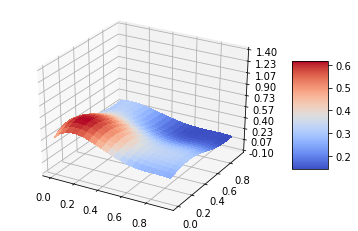

In [12]:
# Plotting predicted plot, similar to the code for plotting the initial plot, except for predicting z

toplot = X @ OLSbetas
testing = toplot.reshape(20,20)

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')

x_create = np.arange(0, 1, 0.05)
y_create = np.arange(0, 1, 0.05)
x_create, y_create = np.meshgrid(x_create,y_create)

surf2 = ax2.plot_surface(x_create, y_create, testing, cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax2.set_zlim(-0.10, 1.40) 
ax2.zaxis.set_major_locator(LinearLocator(10)) 
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors. 
fig2.colorbar(surf2, shrink=0.5, aspect=3)
plt.show()

# Calculate confidence interval for betas

In [13]:
# Caulculate approximation of variance of betas, using sigma squared

def confidence_interval(y_train, y_est, x_train, beta):
    N = len(y_train)
    x_train = pd.DataFrame(data=x_train)
    p = len(x_train.columns) 
    
    
    # calculating residuals, rss and sigma_squared
    residuals = y_train - y_est
    rss = residuals.T @ residuals
    sigma_sq = rss/(N-p)
    # calculating variance of betas
    var_beta = np.linalg.pinv(x_train.T @ x_train) * sigma_sq
    
    se = []
    
    # for loop for standard errors
    for i in range(p):
        standard_error = np.sqrt(var_beta[i, i])
        se.append(standard_error)
        
    se = pd.DataFrame(data=se)
    se.rename(columns={se.columns[0]: "SE" }, inplace = True)
    beta = pd.DataFrame(data=beta)
    beta.rename(columns={beta.columns[0]: "mu" }, inplace = True)

    table = pd.concat([se,beta],axis=1)
    
    table['95_upper'] = table['mu'] + 1.96*table['SE']
    table['95_lower'] = table['mu'] - 1.96*table['SE']
        
    return table[['95_lower','mu','95_upper']]
print(confidence_interval(y_train, ytildeOLS, X_train_scaled, OLSbetas))

    95_lower        mu   95_upper
0   0.415714  0.420726   0.425739
1   1.613159  1.853123   2.093088
2   0.802525  1.051402   1.300279
3  -8.609044 -7.432147  -6.255251
4  -3.694575 -2.943673  -2.192772
5  -3.549998 -2.325661  -1.101324
6   5.338501  7.886050  10.433599
7   5.482012  6.857998   8.233984
8   2.744478  4.178333   5.612187
9  -5.283318 -2.655156  -0.026993
10 -3.811649 -1.259101   1.293446
11 -8.701867 -7.373919  -6.045972
12 -1.743269 -0.558156   0.626956
13 -7.085221 -5.695233  -4.305245
14  5.234336  7.856917  10.479499
15 -2.201803 -1.236701  -0.271598
16  1.897369  2.448280   2.999191
17  0.440204  0.917485   1.394766
18 -1.136312 -0.638323  -0.140333
19  2.249404  2.822202   3.395000
20 -5.044880 -4.056465  -3.068050


# Add stochastic noise term
- Standard normal distribution

In [14]:
# Doing the samee but adding noise term

poly,y2 = make_Xy(x_create,y_create,z_create)

poly = pd.DataFrame(data=poly)
poly = poly.applymap(lambda x: x + np.random.rand()/100)
poly = poly.values
X2 = matrixfull(poly)

# Using split, train, test function like in the homework sets from Morten Hjorth-Jensen

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2) 

# Normalizing training data

scaler_noise = StandardScaler()
scaler_noise.fit(X_train2)
X_train_scaled2 = scaler_noise.transform(X_train2)
X_test_scaled2 = scaler_noise.transform(X_test2)
X_train_scaled2[:, 0] =  1
X_test_scaled2[:, 0] =  1

# Calculating betas using linear algebra

OLSbetas2 = np.linalg.inv(X_train_scaled2.T @ X_train_scaled2) @ X_train_scaled2.T @ y_train2

# Making prediction

ytildeOLS2 = X_train_scaled2 @ OLSbetas2
ypredictOLS2 = X_test_scaled2 @ OLSbetas2

print("Training R2 for OLS")
print(R2(y_train2,ytildeOLS2))
print("Training MSE for OLS")
print(MSE(y_train2,ytildeOLS2))
print('')
print("Test R2 for OLS")
print(R2(y_test2,ypredictOLS2))
print("Test MSE OLS")
print(MSE(y_test2,ypredictOLS2))

Training R2 for OLS
0.9732160209351025
Training MSE for OLS
0.0022355948517088983

Test R2 for OLS
0.9692811132423111
Test MSE OLS
0.002219381137640212


# MSE

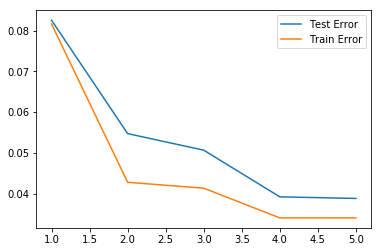

In [15]:
# The code is very similar to the homework-code but tweaked to fit the assignment

X,y = make_Xy(x_create,y_create,z_create)


maxdegree = 5

TestError = np.zeros(maxdegree)
TrainError = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)



for degree in range(maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=True))
    
    np.random.seed(4155)

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled[:, 0] =  1
    X_test_scaled[:, 0] =  1
    
    clf = model.fit(X_train_scaled,y_train)
    y_fit = clf.predict(X_train_scaled)
    y_pred = clf.predict(X_test_scaled) 
    polydegree[degree] = degree
    TestError[degree] = np.mean( np.mean((y_test - y_pred)**2) )
    TrainError[degree] = np.mean( np.mean((y_train - y_fit)**2) )

plt.plot(polydegree+1, TestError, label='Test Error')
plt.plot(polydegree+1, TrainError, label='Train Error')
plt.legend()
plt.show()

Polynomial degree: 0
Error: 0.08273062536920087
Bias^2: 0.0824831985712948
Var: 0.00024742679790606194
0.08273062536920087 >= 0.0824831985712948 + 0.00024742679790606194 = 0.08273062536920085
Polynomial degree: 1
Error: 0.03115589448046972
Bias^2: 0.030935931728401485
Var: 0.00021996275206823202
0.03115589448046972 >= 0.030935931728401485 + 0.00021996275206823202 = 0.031155894480469716
Polynomial degree: 2
Error: 0.023300765970160082
Bias^2: 0.022929336268989305
Var: 0.00037142970117078007
0.023300765970160082 >= 0.022929336268989305 + 0.00037142970117078007 = 0.023300765970160085
Polynomial degree: 3
Error: 0.010124822643488532
Bias^2: 0.009834557153791817
Var: 0.0002902654896967126
0.010124822643488532 >= 0.009834557153791817 + 0.0002902654896967126 = 0.01012482264348853
Polynomial degree: 4
Error: 0.005913319718484536
Bias^2: 0.00557385126849178
Var: 0.00033946844999275426
0.005913319718484536 >= 0.00557385126849178 + 0.00033946844999275426 = 0.005913319718484534


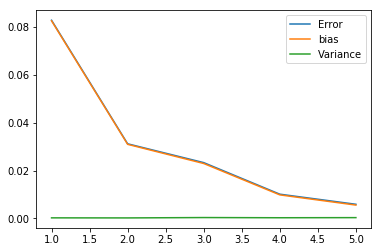

In [16]:
# Making error plot, also similar to the homework code

X,y = make_Xy(x_create,y_create,z_create)

n_boostraps = 100
maxdegree = 5

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

np.random.seed(4155)

y_test = y_test.reshape(80,1)

for degree in range(maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(X_train, y_train)
        y_pred[:, i] = model.fit(x_, y_).predict(X_test).ravel()

    polydegree[degree] = degree+1
    error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    print('Polynomial degree:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
plt.show()

### Bootstrapping

Polynomial degree: 0
Error: 0.08272130815456187
Bias^2: 0.08247021758682119
Var: 0.0002510905677406754
0.08272130815456187 >= 0.08247021758682119 + 0.0002510905677406754 = 0.08272130815456186
Polynomial degree: 1
Error: 0.055194905236071755
Bias^2: 0.05480685059286041
Var: 0.00038805464321133454
0.055194905236071755 >= 0.05480685059286041 + 0.00038805464321133454 = 0.05519490523607175
Polynomial degree: 2
Error: 0.051216253837735225
Bias^2: 0.05066176737529589
Var: 0.0005544864624393396
0.051216253837735225 >= 0.05066176737529589 + 0.0005544864624393396 = 0.051216253837735225
Polynomial degree: 3
Error: 0.039685260585672746
Bias^2: 0.03904729002522993
Var: 0.0006379705604428133
0.039685260585672746 >= 0.03904729002522993 + 0.0006379705604428133 = 0.03968526058567274
Polynomial degree: 4
Error: 0.03969498325180051
Bias^2: 0.03887656578835798
Var: 0.0008184174634425282
0.03969498325180051 >= 0.03887656578835798 + 0.0008184174634425282 = 0.03969498325180051


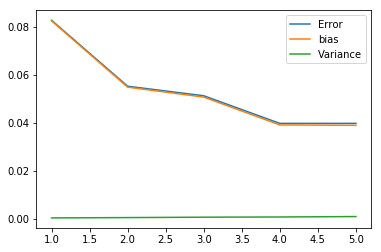

None


In [17]:
X,y = make_Xy(x_create,y_create,z_create)


def bootstrap(X,y,n,maxdegree,size):
    
    # Making empty dataframes
    
    error = np.zeros(maxdegree)
    bias = np.zeros(maxdegree)
    variance = np.zeros(maxdegree)
    polydegree = np.zeros(maxdegree)

    
    # Looping through all polynomial degrees, not required for assignment but for deeper understanding
    for degree in range(maxdegree):
        
        np.random.seed(4155)
        
        # Regular fitting for all polynomials
        
        model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=True), LinearRegression(fit_intercept=True))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
    
        y_pred = np.empty((y_test.shape[0], n_boostraps))
    
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled[:, 0] =  1
        X_test_scaled[:, 0] =  1
    
        y_test = y_test.reshape(len(y_test),1)
    
        # Bootstrapping for all polynomial degrees
        
        for i in range(n_boostraps):
            
            # Using resample code from sklearn
            
            x_, y_ = resample(X_train_scaled, y_train)
            y_pred[:, i] = model.fit(x_, y_).predict(X_test_scaled).ravel()
    
        # Adding +1 to degree so that it counts from 1 (looks better in the plot)
        polydegree[degree] = degree+1
        
        # Calculating error, bias and variance
        error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        print('Polynomial degree:', degree)
        print('Error:', error[degree])
        print('Bias^2:', bias[degree])
        print('Var:', variance[degree])
        print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

    plt.plot(polydegree, error, label='Error')
    plt.plot(polydegree, bias, label='bias')
    plt.plot(polydegree, variance, label='Variance')
    plt.legend()
    print(plt.show())
    
    return error, bias, variance

error, bias, variance = bootstrap(poly,y,500,5,0.2)

# Ridge Regression

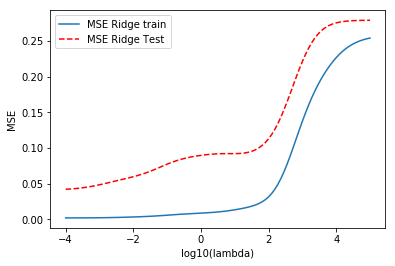

In [18]:
poly,y = make_Xy(x_create,y_create,z_create)
X = matrixfull(poly)

# Ridge_clean is mostly taken from homework set and is used to see difference between this and the one
# which also employs bootstrapping

def ridge_clean(X,y,nlambdas):
    # We split the data in test and training data
    X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(X, y, test_size=0.2) 
    scaler_ridge = StandardScaler()
    scaler_ridge.fit(X_train_ridge)
    X_train_scaled_ridge = scaler_ridge.transform(X_train_ridge)
    X_test_scaled_ridge = scaler_ridge.transform(X_test_ridge)
    X_train_scaled_ridge[:, 0] =  1
    X_test_scaled_ridge[:, 0] =  1

    # matrix inversion to find beta
    OLSbeta_ridge = np.linalg.pinv(X_train_scaled_ridge.T @ X_train_scaled_ridge) @ X_train_scaled_ridge.T @ y_train_ridge 


    # Repeat now for Ridge regression and various values of the regularization parameter 
    I = np.identity(21)
    # Decide which values of lambda to use
    MSEPredict = np.zeros(nlambdas) 
    MSETrain = np.zeros(nlambdas)
    lambdas = np.logspace(-4, 5, nlambdas) 

    error = np.zeros((nlambdas,maxdegree))
    bias = np.zeros((nlambdas,maxdegree))
    variance = np.zeros((nlambdas,maxdegree))
    polydegree = np.zeros((nlambdas,maxdegree))

    for i in range(nlambdas):
        lmb = lambdas[i]
        Ridgebeta = np.linalg.pinv(X_train_scaled_ridge.T @ X_train_scaled_ridge+(lmb*I)) @ (X_train_scaled_ridge.T @ y_train_ridge) # and then make the prediction
        ytildeRidge = X_train_scaled_ridge @ Ridgebeta
        ypredictRidge = X_test_ridge @ Ridgebeta
        MSEPredict[i] = MSE(y_test_ridge,ypredictRidge)
        MSETrain[i] = MSE(y_train_ridge,ytildeRidge)

    
    
# Now plot the resulys 

    plt.figure() 
    plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Ridge train')  
    plt.plot(np.log10(lambdas), MSEPredict, 'r--', label = 'MSE Ridge Test') 
    plt.xlabel('log10(lambda)') 
    plt.ylabel('MSE') 
    plt.legend()
    plt.show()
    
ridge_clean(X,y,100)

<Figure size 432x288 with 0 Axes>

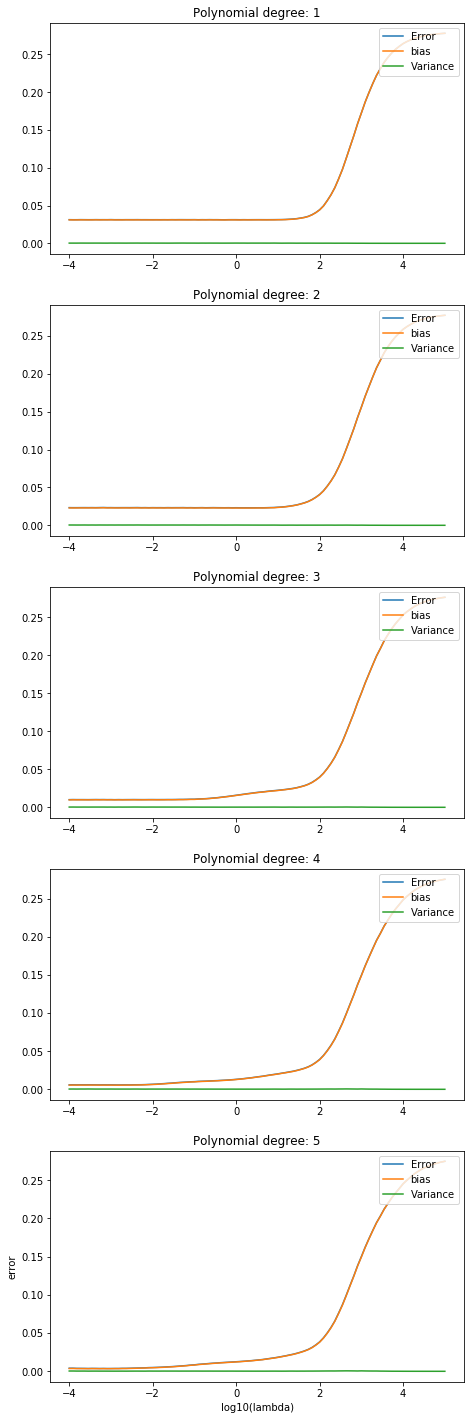

Ridge with bootstraps took 10.393326044082642 seconds to run


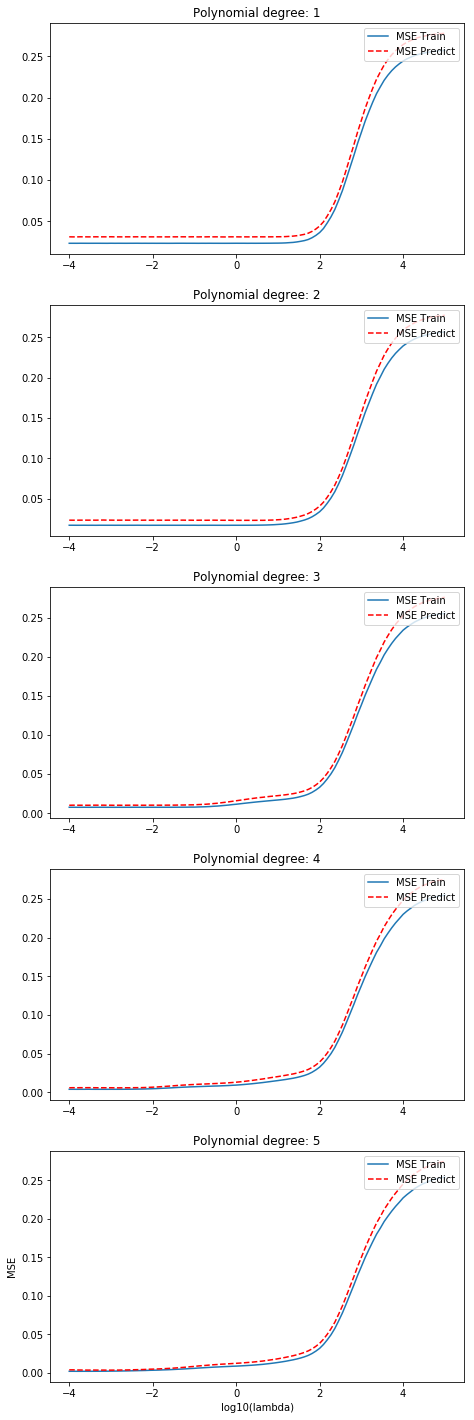

In [19]:
poly,y = make_Xy(x_create,y_create,z_create)


def ridge_bootstrap(poly,y,maxdegree,nlambdas,n_bootstraps2):
    
    # time.time() is just to time the function
    start_time = time.time()
    
    # Making lambda vector and empty arrays
    lambdas = np.logspace(-4, 5, nlambdas) 
    error = np.zeros((maxdegree,nlambdas))
    bias = np.zeros((maxdegree,nlambdas))
    variance = np.zeros((maxdegree,nlambdas))
    MSEPredict = np.zeros((maxdegree,nlambdas))
    MSETrain = np.zeros((maxdegree,nlambdas))

    # Looping through polynomial degrees
    for m in range(1,maxdegree+1):
        X = PolynomialFeatures(degree=m, include_bias=True).fit_transform(poly)
    
        # Regular fitting
        np.random.seed(4155)
        X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(X, y, test_size=0.2)
        scaler_ridge = StandardScaler()
        scaler_ridge.fit(X_train_ridge)
        X_train_scaled_ridge = scaler_ridge.transform(X_train_ridge)
        X_test_scaled_ridge = scaler_ridge.transform(X_test_ridge)
        X_train_scaled_ridge[:, 0] =  1
        X_test_scaled_ridge[:, 0] =  1
    
        # matrix inversion to find beta
        OLSbeta_ridge = np.linalg.pinv(X_train_scaled_ridge.T @ X_train_scaled_ridge) @ X_train_scaled_ridge.T @ y_train_ridge
        # Make prediction prediction
        ytildeOLS_ridge = X_train_scaled_ridge @ OLSbeta_ridge
    
        # Extracting shape to get the correct n for the identity matrix
        num_rows, num_cols = X.shape
        I = np.identity(num_cols)
    
        # Looping through lambdas
        for i in range(nlambdas):
            y_pred = np.empty((y_test_ridge.shape[0], n_boostraps))
            y_tilde = np.empty((y_train_ridge.shape[0], n_boostraps))
            lmb = lambdas[i]
    
            # Looping through bootstraps
            for j in range(n_boostraps):
                x_, y_ = resample(X_train_scaled_ridge, y_train_ridge)
                Ridgebeta = np.linalg.pinv(x_.T @ x_+(lmb*I)) @ (x_.T @ y_)
                y_pred[:,j] = (X_test_scaled_ridge @ Ridgebeta).reshape(len(X_test_scaled_ridge[:,0]),)
                y_tilde[:,j] = (X_train_scaled_ridge @ Ridgebeta).reshape(len(X_train_scaled_ridge[:,0]),)
            
        
        
            # Saving predictions
            error[m-1:,i] = np.mean( np.mean((y_test_ridge - y_pred)**2, axis=1, keepdims=True) )
            bias[m-1:,i] = np.mean( (y_test_ridge - np.mean(y_pred, axis=1, keepdims=True))**2 )
            variance[m-1:,i] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
            MSEPredict[m-1,i] = MSE(y_test_ridge,y_pred)
            MSETrain[m-1,i] = MSE(y_train_ridge,y_tilde)
    
    # Making plot functions to plot all the polynomial degrees. I decided against using this in the paper
    # because it doesn't add that much
    def plotbiasvar(maxdegree,error,bias,variance):
    
        n = maxdegree
        columns = 1
        fig, axes = plt.subplots(n, columns,figsize=(7,20))
        fig.tight_layout(pad=3.0)
    
        for i in list(range(maxdegree)):
        
            poly = i+1
    
            x1 = error[i]
            x2 = bias[i]
            x3 = variance[i]
        
            axes[i].plot(np.log10(lambdas), x1, label='Error')
            axes[i].plot(np.log10(lambdas), x2, label='bias')
            axes[i].plot(np.log10(lambdas), x3, label='Variance')
            axes[i].legend(loc='upper right')
            #axes[i].set_ylim([0, 30])
            axes[i].set_title('Polynomial degree: ' + str(poly))
            plt.xlabel('log10(lambda)') 
            plt.ylabel('error')
    plt.savefig("Polydegree_" + str(i) +".png", format="PNG")
    plt.show()
    
    
    plotbiasvar(maxdegree,error,bias,variance)
    
    

    def plotmse(maxdegree,MSEPredict,MSETrain):
        n = maxdegree
        columns = 1
        fig, axes = plt.subplots(n, columns,figsize=(7,20))
        fig.tight_layout(pad=3.0)
    
        for i in list(range(maxdegree)):
            poly = i+1
            axes[i].plot(np.log10(lambdas), MSETrain[i], label='MSE Train')
            axes[i].plot(np.log10(lambdas), MSEPredict[i], 'r--', label='MSE Predict')
            axes[i].legend(loc='upper right')
            #axes[i].set_ylim([0, 30])
            axes[i].set_title('Polynomial degree: ' + str(poly))
            plt.xlabel('log10(lambda)') 
            plt.ylabel('MSE')
        
    plt.show()
    
    print("Ridge with bootstraps took", time.time() - start_time, "seconds to run")


    plotmse(maxdegree,MSEPredict,MSETrain)
   
ridge_bootstrap(poly,y,5,100,100)

# Lasso Regression

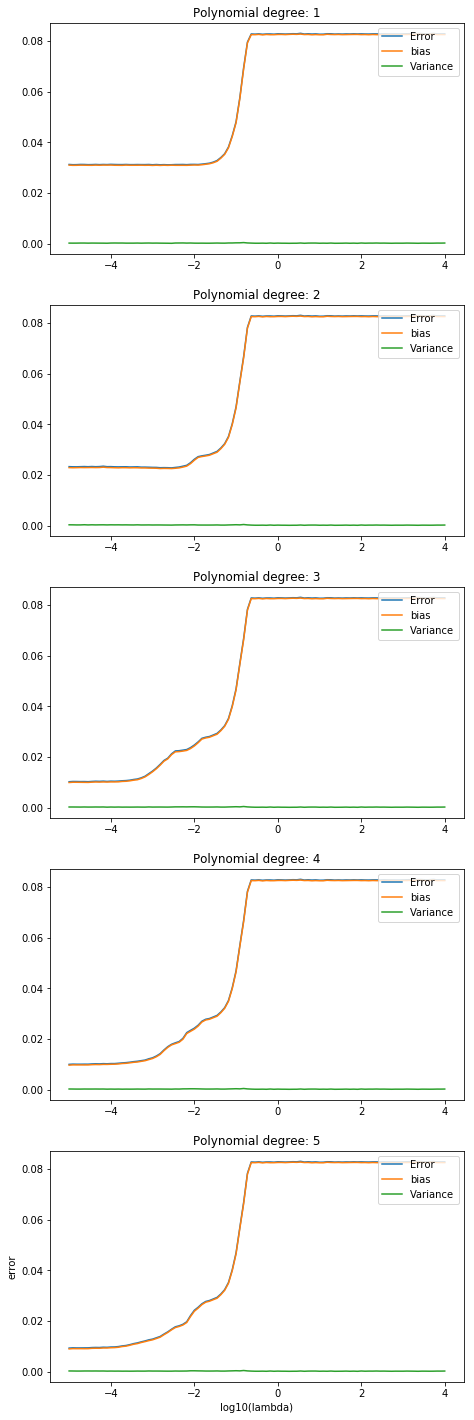

Lasso with bootstraps and cross validation took 42.08446979522705 seconds to run


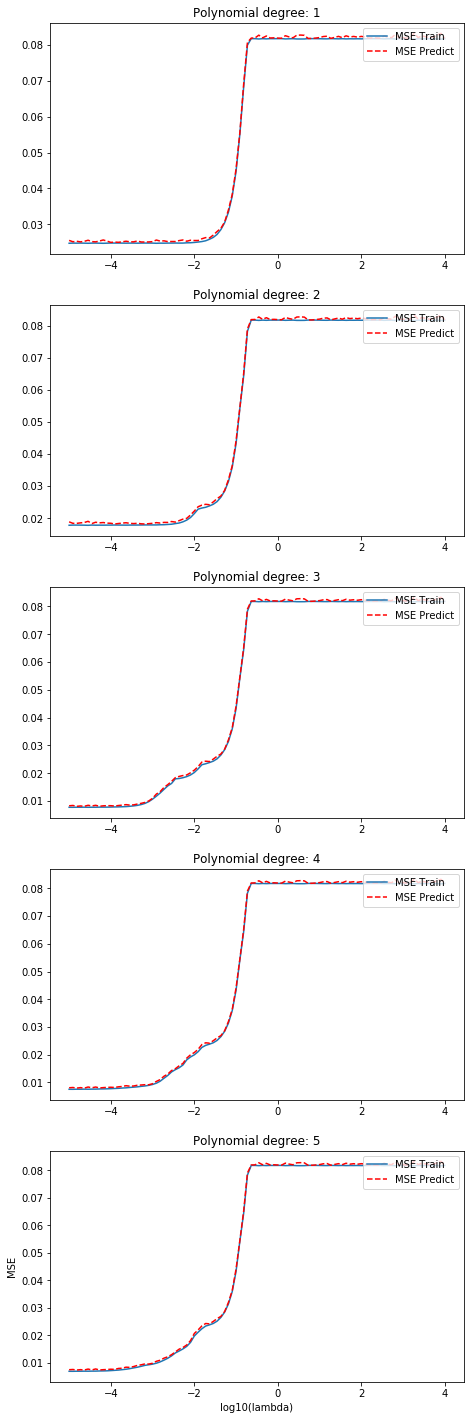

In [20]:
import sklearn.linear_model as skl
poly,y = make_Xy(x_create,y_create,z_create)

# Making lasso function
def lasso_cross_boot(poly,y,maxdegree,nlambdas,n_bootstraps,k):
    # Timing the function
    start_time = time.time()
    
    # Making lambda vector and empty arrays
    lambdas = np.logspace(-5, 4, nlambdas) 
    error_lasso = np.zeros((maxdegree,nlambdas))
    bias_lasso = np.zeros((maxdegree,nlambdas))
    variance_lasso = np.zeros((maxdegree,nlambdas))
    MSEPredict_lasso = np.zeros((maxdegree,nlambdas))
    MSETrain_lasso = np.zeros((maxdegree,nlambdas))

    # Looping through all polynomial degrees
    for m in range(1,maxdegree+1):
        X = PolynomialFeatures(degree=m, include_bias=True).fit_transform(poly)
    
        np.random.seed(4155)
    
        # Regular fit
        X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X, y, test_size=0.2) 
        scaler_lasso = StandardScaler()
        scaler_lasso.fit(X_train_lasso)
        X_train_scaled_lasso = scaler_lasso.transform(X_train_lasso)
        X_test_scaled_lasso = scaler_lasso.transform(X_test_lasso)
        X_train_scaled_lasso[:, 0] =  1
        X_test_scaled_lasso[:, 0] =  1
    
        # Making prediction for all lambdas
        for i in range(nlambdas):
            y_pred_lasso = np.empty((y_test_lasso.shape[0], n_boostraps))
            y_tilde_lasso = np.empty((y_train_lasso.shape[0], n_boostraps))
            lmb = lambdas[i]
        
            # And for all bootstraps, using built-in lasso function
            for j in range(n_boostraps):
                x_, y_ = resample(X_train_scaled_lasso, y_train_lasso)
                clf_lasso = skl.Lasso(alpha=lmb).fit(x_, y_)
                y_pred_lasso[:,j] = clf_lasso.predict(X_test_scaled_lasso).reshape(len(X_test_scaled_lasso[:,0]),)
                y_tilde_lasso[:,j] = clf_lasso.predict(X_train_scaled_lasso).reshape(len(X_train_scaled_lasso[:,0]),)            
        
            # Saving errors
            error_lasso[m-1:,i] = np.mean( np.mean((y_test_lasso - y_pred_lasso)**2, axis=1, keepdims=True) )
            bias_lasso[m-1:,i] = np.mean( (y_test_lasso - np.mean(y_pred_lasso, axis=1, keepdims=True))**2 )
            variance_lasso[m-1:,i] = np.mean( np.var(y_pred_lasso, axis=1, keepdims=True) )
            
    for s in range(nlambdas):
        R2train,R2test,MSETrain_lasso[:,s],MSEPredict_lasso[:,s] = crossval_lasso(poly, y, k, lambdas[s],maxdegree)
        
        
    # Plotting again, like in the case of ridge, see comments
    def plotbiasvar(maxdegree,error,bias,variance):
    
        n = maxdegree
        columns = 1
        fig, axes = plt.subplots(n, columns,figsize=(7,20))
        fig.tight_layout(pad=3.0)
    
        for i in list(range(maxdegree)):
        
            poly = i+1
    
            x1 = error[i]
            x2 = bias[i]
            x3 = variance[i]
        
            axes[i].plot(np.log10(lambdas), x1, label='Error')
            axes[i].plot(np.log10(lambdas), x2, label='bias')
            axes[i].plot(np.log10(lambdas), x3, label='Variance')
            axes[i].legend(loc='upper right')
            #axes[i].set_ylim([0, 30])
            axes[i].set_title('Polynomial degree: ' + str(poly))
            plt.xlabel('log10(lambda)') 
            plt.ylabel('error')

    plt.show()
    
    plotbiasvar(maxdegree,error_lasso,bias_lasso,variance_lasso)

    def plotmse(maxdegree,MSEPredict,MSETrain):
        n = maxdegree
        columns = 1
        fig, axes = plt.subplots(n, columns,figsize=(7,20))
        fig.tight_layout(pad=3.0)
    
        for i in list(range(maxdegree)):
            poly = i+1
            axes[i].plot(np.log10(lambdas), MSETrain[i], label='MSE Train')
            axes[i].plot(np.log10(lambdas), MSEPredict[i], 'r--', label='MSE Predict')
            axes[i].legend(loc='upper right')
            #axes[i].set_ylim([0, 30])
            axes[i].set_title('Polynomial degree: ' + str(poly))
            plt.xlabel('log10(lambda)') 
            plt.ylabel('MSE')
        
    plt.show()
    
    print("Lasso with bootstraps and cross validation took", time.time() - start_time, "seconds to run")

    plotmse(maxdegree,MSEPredict_lasso,MSETrain_lasso)
    
@ignore_warnings(category=ConvergenceWarning)
def my_function2():
    lasso_cross_boot(poly,y,5,100,100,5)
    
my_function2()

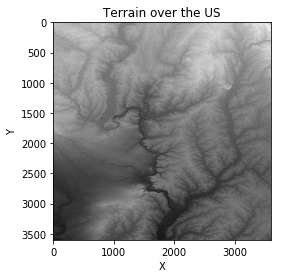

In [21]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

from PIL import Image

# Load the terrain
terrain1 = imread('mapUS.tif') # Show the terrain
plt.figure()
plt.title('Terrain over the US') 
plt.imshow(terrain1, cmap='gray') 
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

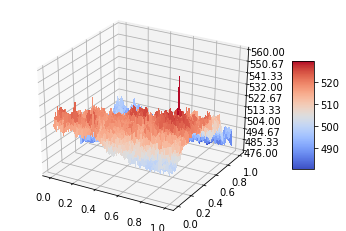

In [22]:
# Choosing a subset of the terrain due to computational issues and plotting like before
t = 400
terrain2 = terrain1[0:t,0:t]
img_arr = np.array(terrain2)
img_rows, img_cols = terrain2.shape
x_createimg = np.arange(0, 1, 1/img_rows)
y_createimg = np.arange(0, 1, 1/img_cols)
fig = plt.figure()
ax = fig.gca(projection='3d')

x_createimg, y_createimg = np.meshgrid(x_createimg,y_createimg)


# Plot the surface.
surf_img = ax.plot_surface(x_createimg, y_createimg, terrain2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.

ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf_img, shrink=0.5, aspect=5)
plt.show()

In [23]:
# Making arrays like previously

x_img = x_createimg.ravel().T.reshape(img_rows*img_cols,1)
y__img = y_createimg.ravel().T.reshape(img_rows*img_cols,1)
y_img = terrain2.ravel().reshape(img_rows*img_cols,1)
matrix_img = np.stack((x_img,y__img)).T.reshape(len(x_img),2)

X_img = matrixfull(matrix_img)
OLSbetas_img,ytildeOLS_img,y_train_img,X_train_scaled_img = ols_regular(X_img,y_img)

Training R2 for OLS
0.908008893748866
Training MSE for OLS
16.13595445696528

Test R2 for OLS
0.9098603681006263
Test MSE OLS
15.912689535390836
Regular OLS took 0.12127518653869629 seconds to run


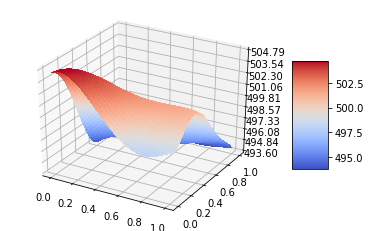

In [24]:
# Plotting predictions like with Franke's Function

toplot_img = X_img @ OLSbetas_img
testing_img = toplot_img.reshape(t,t)
fig2_img = plt.figure()
ax2_img = fig2_img.gca(projection='3d')

x_createimg = np.arange(0, 1, 1/img_rows)
y_createimg = np.arange(0, 1, 1/img_cols)
x_createimg, y_createimg = np.meshgrid(x_createimg,y_createimg)

surf2_img = ax2_img.plot_surface(x_createimg, y_createimg, testing_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax2_img.zaxis.set_major_locator(LinearLocator(10)) 
ax2_img.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors. 
fig2_img.colorbar(surf2_img, shrink=0.5, aspect=3)
plt.show()

<Figure size 432x288 with 0 Axes>

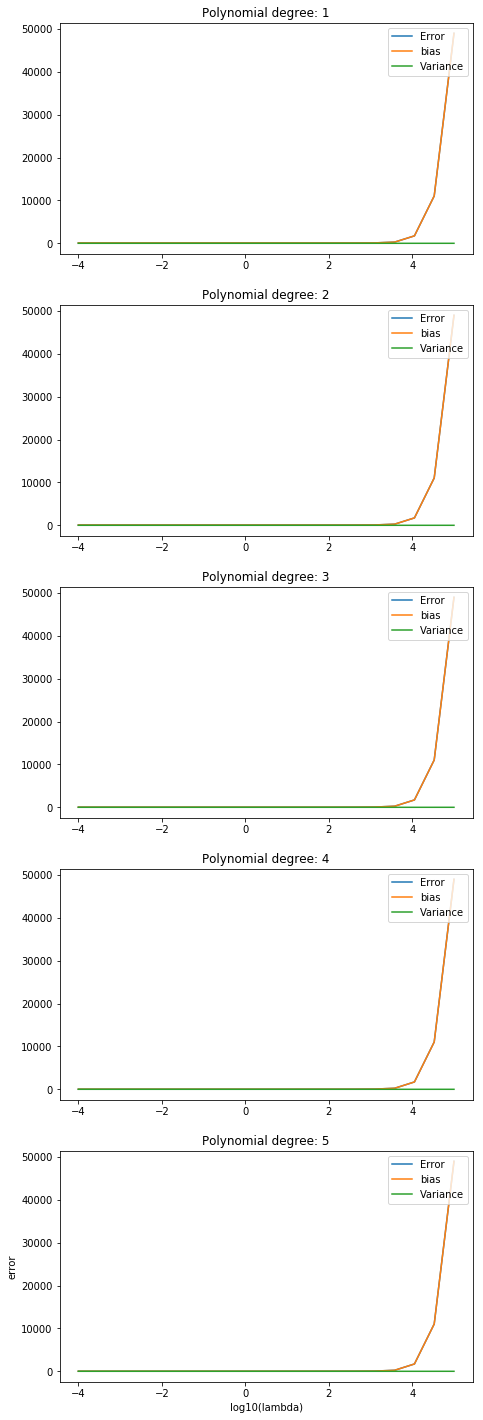

Ridge with bootstraps took 132.83184170722961 seconds to run


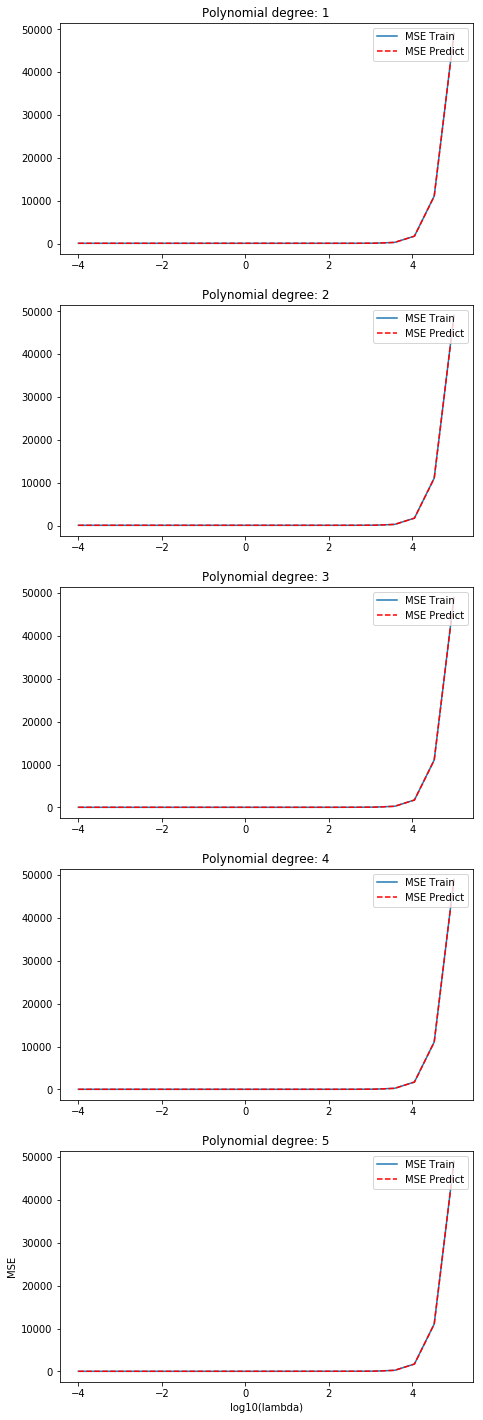

In [25]:
ridge_bootstrap(matrix_img,y_img,5,20,20)

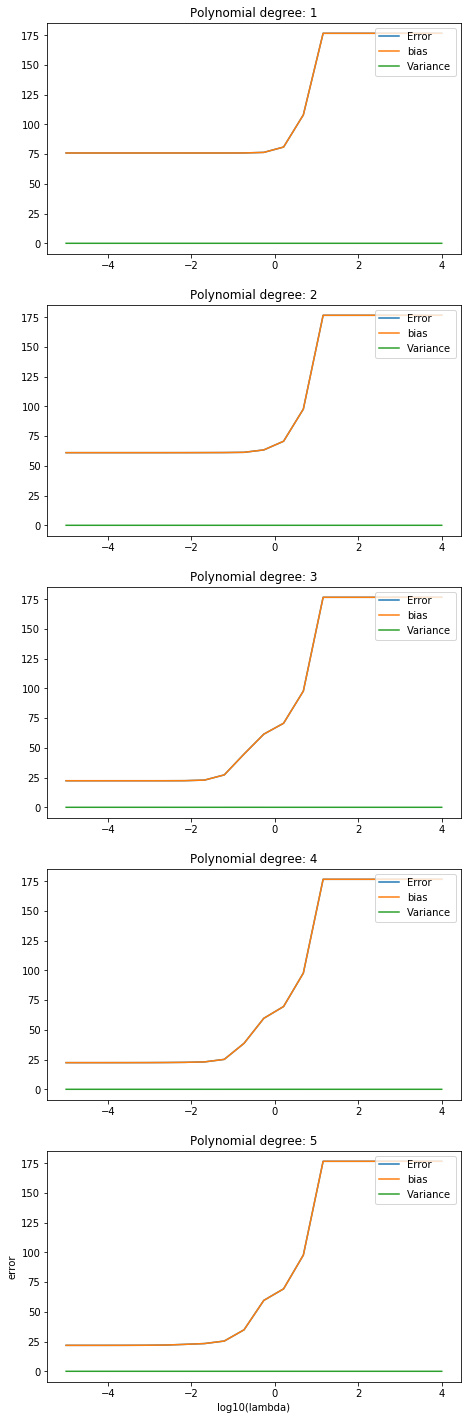

Lasso with bootstraps and cross validation took 3522.766134738922 seconds to run


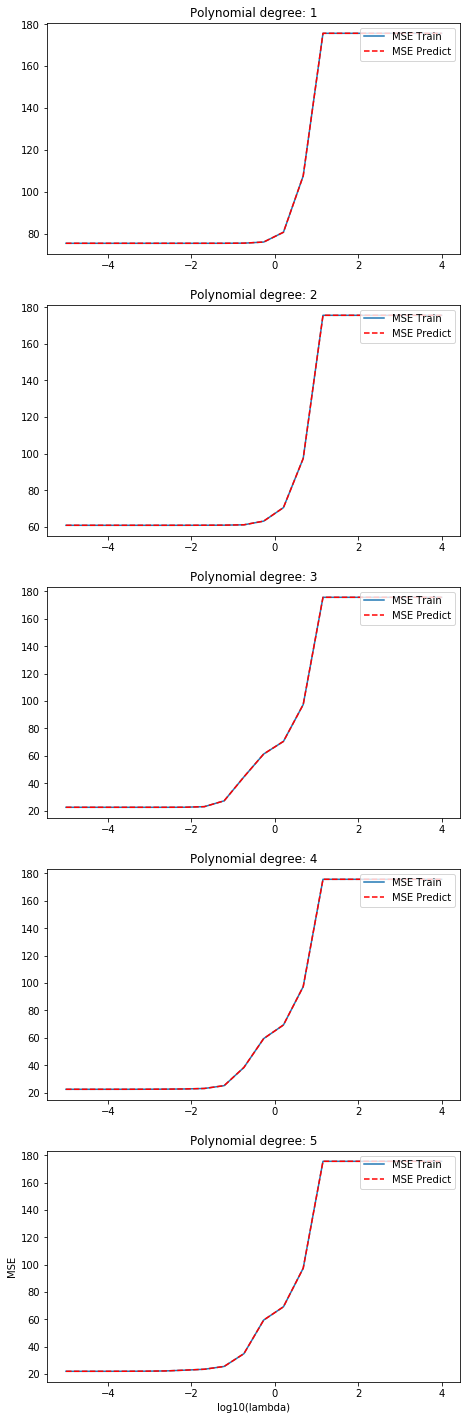

In [26]:
@ignore_warnings(category=ConvergenceWarning)
def my_function3():
    lasso_cross_boot(matrix_img,y_img,5,20,20,5)
    
my_function3()

